# Extração e Leitura de Bases, EDA e Análises Gerais

* extração de dados do Google Trends
* leitura dos dados da B3
    - ano de 2020
    - ações Magazine e Luiza e Via Varejo
    - divisão em mercado a vista e fracionário

### dados do google trends

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
pd.set_option('display.max_columns', 0)

#### buscando dados armazenados no servidor dos EUA (hl = 'en-US')

In [2]:
pytrends = TrendReq(hl = 'en-US', tz = 360)

# lista de palavras a serem pesquisadas
kw_list = ['MGLU3', 'VVAR3']

os parâmetros são:
* lista de palavras
* categoria (0 = todas)
* período de tempo (é possível especificar um período de data: timeframe = '2022-01-01 2022-06-01' para 01/jan até 01/jun)
* região geográfica (se ficar em branco é mundial)
* tipo de dados (pode ser 'images', 'news', 'youtube')

In [3]:
pytrends.build_payload(kw_list, cat = 0, timeframe = '2020-01-01 2020-12-31', geo = 'BR', gprop = '')

# retorna um dataframe pandas
palavras_trend = pytrends.interest_over_time()

In [4]:
# amostra
palavras_trend.head()

,MGLU3,VVAR3,isPartial
date,,,
2020-01-05,27,30,False
2020-01-12,27,51,False
2020-01-19,24,49,False
2020-01-26,28,50,False
2020-02-02,26,37,False


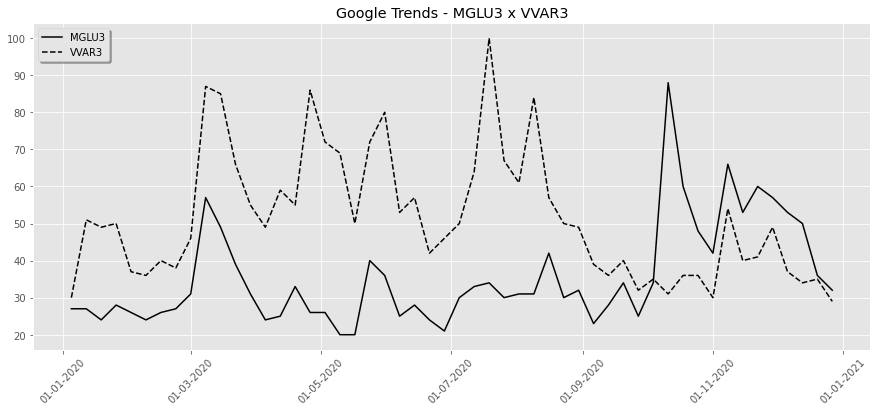

In [5]:
# gráfico de tendência das palavras pesquisadas
plt.style.use('ggplot')
fig = plt.figure(figsize = (15, 6))
ax1 = plt.subplot(111)
plt.title('Google Trends - MGLU3 x VVAR3')

ax1.plot(palavras_trend[kw_list[0]], '-k', palavras_trend[kw_list[1]], '--k')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.setp(ax1.get_xticklabels(), rotation = 45)

plt.legend((kw_list[0], kw_list[1]), loc = 'upper left', shadow = True)

In [6]:
# padronizando os dados
min_max_scaler = MinMaxScaler()

palavras_trend[["MGLU3", "VVAR3"]] = min_max_scaler.fit_transform(palavras_trend[["MGLU3", "VVAR3"]])

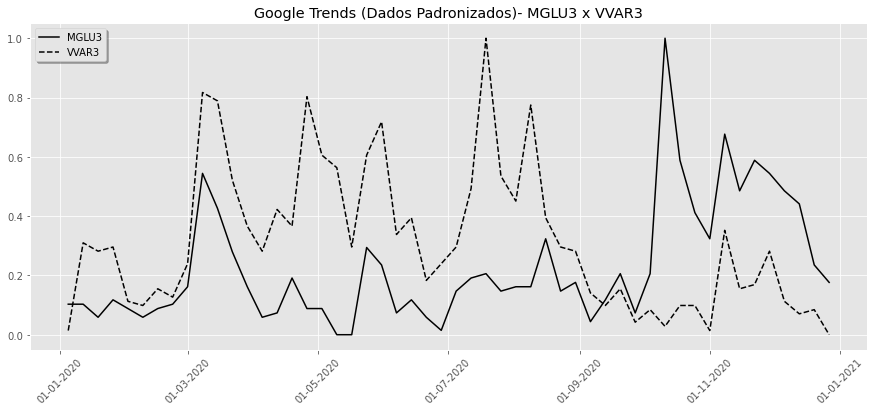

In [7]:
# gráfico de tendência das palavras pesquisadas
plt.style.use('ggplot')
fig = plt.figure(figsize = (15, 6))
ax1 = plt.subplot(111)
plt.title('Google Trends (Dados Padronizados) - MGLU3 x VVAR3')

ax1.plot(palavras_trend[kw_list[0]], '-k', palavras_trend[kw_list[1]], '--k')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.setp(ax1.get_xticklabels(), rotation = 45)

plt.legend((kw_list[0], kw_list[1]), loc = 'upper left', shadow = True)

### dados da B3

In [8]:
# leitura do arquivo - dados diários de 2020
arquivo_b3 = './dados_b3/COTAHIST_A2020.txt'

# com base no layout disponibilizado pela B3
tamanho_campos = [2 ,8, 2, 12, 3, 12, 10, 3, 4, 13, 13, 13, 13, 13, 13, 13, 5, 18, 18, 13, 1, 8, 7, 13, 12, 3]

# dataframe pandas
dados_b3 = pd.read_fwf(arquivo_b3, widths = tamanho_campos)

In [9]:
# nomear colunas
dados_b3.columns = ['tipo_registro', 'data_pregao', 'cod_bdi', 'ticker', 'tipo_mercado', 'empresa', 
                    'especificacao_papel', 'prazo_dias_merc_termo', 'moeda_referencia', 'preco_abertura', 'preco_max', 
                    'preco_min', 'preco_medio', 'preco_ultimo_negocio', 'preco_melhor_oferta_compra', 
                    'preco_melhor_oferta_venda', 'qtd_negocios', 'qtd_papeis_negociados', 'vol_total_negociado', 
                    'preco_exercicio', 'ìndicador_correcao_precos', 'data_vencimento' , 'fator_cotacao', 
                    'preco_exercicio_pontos', 'cod_isin', 'num_distribuicao_papel']

# eliminar trailer do arquivo
linha = len(dados_b3['data_pregao'])
dados_b3 = dados_b3.drop(linha-1)

# alterar tipo da data
dados_b3['data_pregao'] = pd.to_datetime(dados_b3['data_pregao'], format='%Y/%m/%d')
dados_b3.set_index('data_pregao', inplace = True)

# ajustar valores para decimal
lista_dec = ['preco_abertura', 'preco_max', 'preco_min', 'preco_medio', 'preco_ultimo_negocio', 'preco_melhor_oferta_compra', 
           'preco_melhor_oferta_venda', 'vol_total_negociado', 'preco_exercicio', 'preco_exercicio_pontos']

for coluna in lista_dec:
    dados_b3[coluna]=[i/100. for i in dados_b3[coluna]]

In [10]:
# amostra
dados_b3.head()

,tipo_registro,cod_bdi,ticker,tipo_mercado,empresa,especificacao_papel,prazo_dias_merc_termo,moeda_referencia,preco_abertura,preco_max,preco_min,preco_medio,preco_ultimo_negocio,preco_melhor_oferta_compra,preco_melhor_oferta_venda,qtd_negocios,qtd_papeis_negociados,vol_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,cod_isin,num_distribuicao_papel
data_pregao,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,1,2.0,AALR3,10,ALLIAR,ON NM,NaN,R$,18.29,19.00,18.28,18.68,19.00,18.99,19.01,2443.0,585800.0,10946196.0,0.0,0.0,99991231.0,1.0,0.0,BRAALRACNOR6,101.0
2020-01-02,1,2.0,AAPL34,10,APPLE,DRN,NaN,R$,120.00,121.34,120.00,120.73,121.34,105.50,121.34,9.0,12700.0,1533380.0,0.0,0.0,99991231.0,1.0,0.0,BRAAPLBDR004,131.0
2020-01-02,1,2.0,ABCB4,10,ABC BRASIL,PN EJ N2,NaN,R$,20.00,20.30,19.82,20.05,20.30,20.08,20.30,3979.0,870400.0,17457878.0,0.0,0.0,99991231.0,1.0,0.0,BRABCBACNPR4,133.0
2020-01-02,1,2.0,ABEV3,10,AMBEV S/A,ON EJ,NaN,R$,18.86,19.25,18.78,19.12,19.20,19.19,19.20,31581.0,16011300.0,306234791.0,0.0,0.0,99991231.0,1.0,0.0,BRABEVACNOR1,122.0
2020-01-02,1,2.0,ADHM3,10,ADVANCED-DH,ON,NaN,R$,2.55,2.55,2.35,2.44,2.48,2.48,2.49,307.0,193400.0,471927.0,0.0,0.0,99991231.0,1.0,0.0,BRADHMACNOR9,101.0


### mercado fracionário

In [11]:
# somente dados do mercado fracionário (pequenos investidores, pessoa física)
dados_fracionario = dados_b3.loc[dados_b3['tipo_mercado'] == 20]
print(dados_fracionario.shape)

# somente negociações da Magalu e Via Varejo
tickers_aux = dados_fracionario.loc[(dados_fracionario['ticker'] == 'MGLU3F') | (dados_fracionario['ticker'] == 'VVAR3F')]
print(tickers_aux.shape)

# somente as colunas "necessárias"
tickers = tickers_aux[['ticker', 'empresa', 'preco_abertura', 'preco_ultimo_negocio', 'qtd_negocios', 'qtd_papeis_negociados', 'vol_total_negociado']]

# amostra
tickers.head()

(107155, 25)
(498, 25)


,ticker,empresa,preco_abertura,preco_ultimo_negocio,qtd_negocios,qtd_papeis_negociados,vol_total_negociado
data_pregao,,,,,,,
2020-01-02,MGLU3F,MAGAZ LUIZA,48.00,49.22,5697.0,81070.0,3955780.8
2020-01-02,VVAR3F,VIAVAREJO,11.35,11.72,12008.0,177110.0,2050149.2
2020-01-03,MGLU3F,MAGAZ LUIZA,48.51,49.05,5139.0,69100.0,3389995.1
2020-01-06,MGLU3F,MAGAZ LUIZA,48.07,48.98,6042.0,83800.0,4065671.5
2020-01-03,VVAR3F,VIAVAREJO,11.50,11.58,11080.0,225650.0,2652069.4


In [13]:
# separando ações
mglu_aux = tickers.loc[tickers['ticker'] == 'MGLU3F']
vvar_aux = tickers.loc[tickers['ticker'] == 'VVAR3F']

# removendo outliers com base no z-score (3 DP's)
mglu = mglu_aux[(np.abs(stats.zscore(mglu_aux['vol_total_negociado'])) < 3)]
vvar = vvar_aux[(np.abs(stats.zscore(vvar_aux['vol_total_negociado'])) < 3)]

mglu = mglu[(np.abs(stats.zscore(mglu['qtd_papeis_negociados'])) < 3)]
vvar = vvar[(np.abs(stats.zscore(vvar['qtd_papeis_negociados'])) < 3)]

print(mglu.shape)
print(vvar.shape)

(239, 7)
(242, 7)


In [15]:
# resetando índice e transformando dados da B3 em período semanal
palavras_trend.reset_index(drop=True, inplace = True)

mglu = mglu.resample('7D').mean()
mglu.reset_index(drop=True, inplace = True)

vvar = vvar.resample('7D').mean()
vvar.reset_index(drop=True, inplace = True)

In [17]:
# unindo as duas ações (semanal)
mglu_vvar = pd.merge(mglu, vvar, how = 'inner', left_index=True, right_index=True, suffixes=('_mglu', '_vvar'))
mglu_vvar.head()

,preco_abertura_mglu,preco_ultimo_negocio_mglu,qtd_negocios_mglu,qtd_papeis_negociados_mglu,vol_total_negociado_mglu,preco_abertura_vvar,preco_ultimo_negocio_vvar,qtd_negocios_vvar,qtd_papeis_negociados_vvar,vol_total_negociado_vvar
0,48.456,49.248,5572.6,78458.0,3840575.68,11.488,11.616,9174.6,167406.0,1941295.66
1,52.506,53.180,6396.8,92662.0,4908724.38,12.246,12.574,10066.0,186196.0,2349206.38
2,54.982,54.986,5796.8,78732.0,4341033.48,13.986,14.136,11808.0,209402.0,2955889.56
3,55.802,56.174,5449.2,77904.0,4364484.80,14.780,14.566,12850.8,253546.0,3712469.56
4,57.102,56.792,6217.6,90240.0,5124817.34,14.436,14.630,12107.0,195252.0,2829729.58


In [25]:
# unindo dados do google trends com dados da B3
trend_b3 = pd.merge(palavras_trend, mglu_vvar, left_index = True, right_index = True)
trend_b3.rename(columns = {'MGLU3':'Pesquisas sobre MGLU3', 'VVAR3':'Pesquisas sobre VVAR3'}, inplace = True)
trend_b3.head()

,Pesquisas sobre MGLU3,Pesquisas sobre VVAR3,isPartial,preco_abertura_mglu,preco_ultimo_negocio_mglu,qtd_negocios_mglu,qtd_papeis_negociados_mglu,vol_total_negociado_mglu,preco_abertura_vvar,preco_ultimo_negocio_vvar,qtd_negocios_vvar,qtd_papeis_negociados_vvar,vol_total_negociado_vvar
0,0.102941,0.014085,False,48.456,49.248,5572.6,78458.0,3840575.68,11.488,11.616,9174.6,167406.0,1941295.66
1,0.102941,0.309859,False,52.506,53.180,6396.8,92662.0,4908724.38,12.246,12.574,10066.0,186196.0,2349206.38
2,0.058824,0.281690,False,54.982,54.986,5796.8,78732.0,4341033.48,13.986,14.136,11808.0,209402.0,2955889.56
3,0.117647,0.295775,False,55.802,56.174,5449.2,77904.0,4364484.80,14.780,14.566,12850.8,253546.0,3712469.56
4,0.088235,0.112676,False,57.102,56.792,6217.6,90240.0,5124817.34,14.436,14.630,12107.0,195252.0,2829729.58


In [27]:
# padronizando todos os dados
trend_b3_scaled = pd.DataFrame(min_max_scaler.fit_transform(trend_b3), columns=trend_b3.columns)
trend_b3_scaled.head()

,Pesquisas sobre MGLU3,Pesquisas sobre VVAR3,isPartial,preco_abertura_mglu,preco_ultimo_negocio_mglu,qtd_negocios_mglu,qtd_papeis_negociados_mglu,vol_total_negociado_mglu,preco_abertura_vvar,preco_ultimo_negocio_vvar,qtd_negocios_vvar,qtd_papeis_negociados_vvar,vol_total_negociado_vvar
0,0.102941,0.014085,0.0,0.354908,0.364250,0.005715,0.001566,0.000000,0.437209,0.448388,0.083469,0.068474,0.040740
1,0.102941,0.309859,0.0,0.413135,0.420321,0.043889,0.041729,0.070064,0.484852,0.508466,0.128076,0.100568,0.090129
2,0.058824,0.281690,0.0,0.448732,0.446075,0.016100,0.002341,0.032827,0.594217,0.606422,0.215249,0.140205,0.163585
3,0.117647,0.295775,0.0,0.460521,0.463016,0.000000,0.000000,0.034365,0.644123,0.633388,0.267432,0.215605,0.255190
4,0.088235,0.112676,0.0,0.479211,0.471829,0.035590,0.034881,0.084238,0.622502,0.637401,0.230211,0.116036,0.148310


<AxesSubplot:>

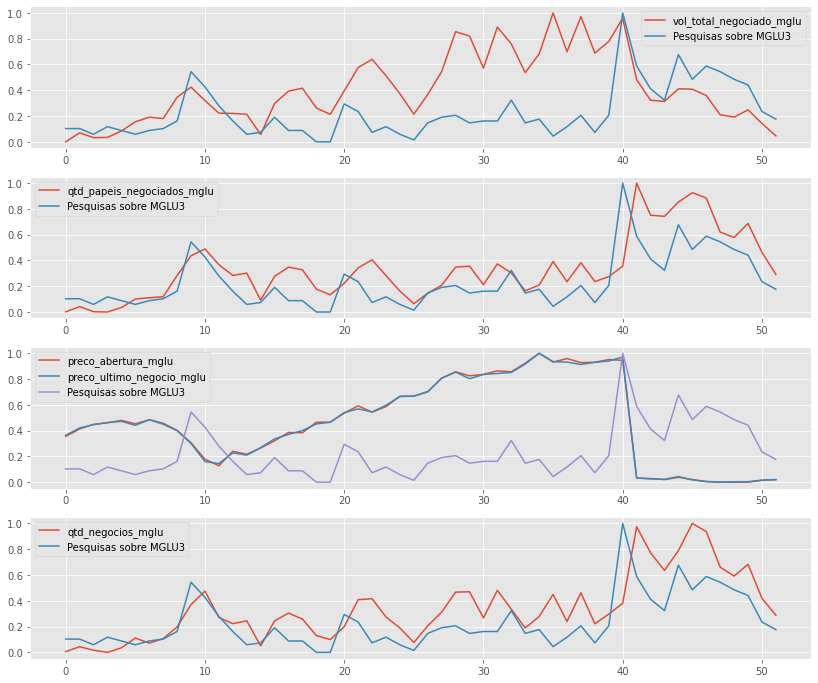

In [29]:
# MGLU3
fig, axes = plt.subplots(nrows = 4, ncols = 1)

trend_b3_scaled[['vol_total_negociado_mglu', 'Pesquisas sobre MGLU3']].plot(ax=axes[0], figsize=(14, 12))
trend_b3_scaled[['qtd_papeis_negociados_mglu', 'Pesquisas sobre MGLU3']].plot(ax=axes[1], figsize=(14, 12))
trend_b3_scaled[['preco_abertura_mglu', 'preco_ultimo_negocio_mglu', 'Pesquisas sobre MGLU3']].plot(ax=axes[2], figsize=(14, 12))
trend_b3_scaled[['qtd_negocios_mglu', 'Pesquisas sobre MGLU3']].plot(ax=axes[3], figsize=(14, 12))

<AxesSubplot:>

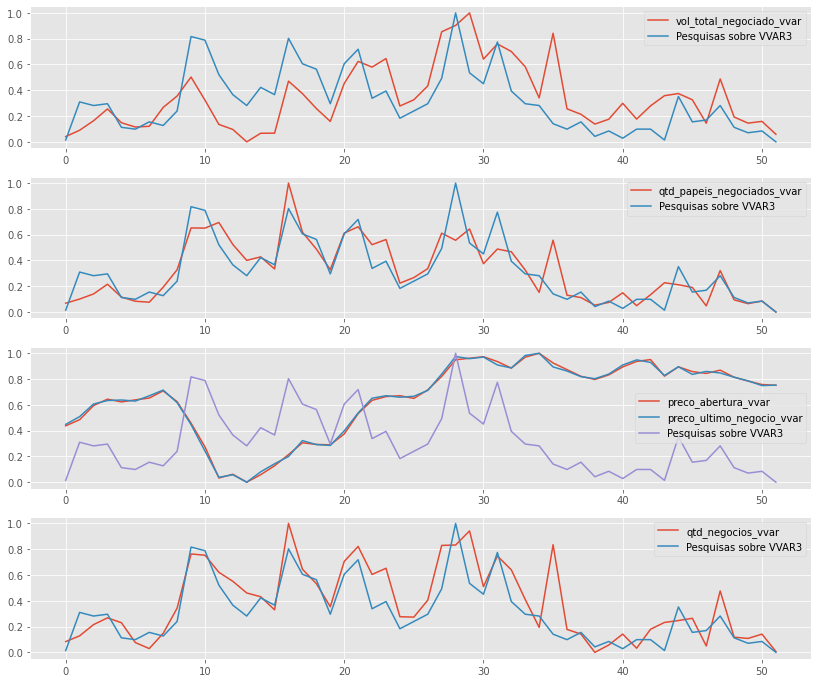

In [32]:
#VVAR3
fig, axes = plt.subplots(nrows = 4, ncols = 1)

trend_b3_scaled[['vol_total_negociado_vvar', 'Pesquisas sobre VVAR3']].plot(ax=axes[0], figsize=(14, 12))
trend_b3_scaled[['qtd_papeis_negociados_vvar', 'Pesquisas sobre VVAR3']].plot(ax=axes[1], figsize=(14, 12))
trend_b3_scaled[['preco_abertura_vvar', 'preco_ultimo_negocio_vvar', 'Pesquisas sobre VVAR3']].plot(ax=axes[2], figsize=(14, 12))
trend_b3_scaled[['qtd_negocios_vvar', 'Pesquisas sobre VVAR3']].plot(ax=axes[3], figsize=(14, 12))

### mercado a vista

In [12]:
# somente dados do mercado a vista
dados_vista = dados_b3.loc[dados_b3['tipo_mercado'] == 10]
print(dados_vista.shape)

# somente negociações da Magalu e Via Varejo
tickers_vista_aux = dados_vista.loc[(dados_vista['ticker'] == 'MGLU3') | (dados_vista['ticker'] == 'VVAR3')]
print(tickers_vista_aux.shape)

# somente as colunas "necessárias"
tickers_vista = tickers_vista_aux[['ticker', 'empresa', 'preco_abertura', 'preco_ultimo_negocio', 'qtd_negocios', 'qtd_papeis_negociados', 'vol_total_negociado']]

# amostra
tickers_vista.head()

(187306, 25)
(498, 25)


,ticker,empresa,preco_abertura,preco_ultimo_negocio,qtd_negocios,qtd_papeis_negociados,vol_total_negociado
data_pregao,,,,,,,
2020-01-02,MGLU3,MAGAZ LUIZA,48.30,49.33,24821.0,7400200.0,361396038.0
2020-01-02,VVAR3,VIAVAREJO,11.33,11.73,77034.0,40413200.0,468686830.0
2020-01-03,MGLU3,MAGAZ LUIZA,48.50,48.89,17631.0,6684400.0,327833288.0
2020-01-06,MGLU3,MAGAZ LUIZA,48.40,48.93,21936.0,6839800.0,332820541.0
2020-01-03,VVAR3,VIAVAREJO,11.47,11.48,48956.0,59501300.0,695592026.0


In [14]:
# separando ações
mglu_vista_aux = tickers_vista.loc[tickers_vista['ticker'] == 'MGLU3']
vvar_vista_aux = tickers_vista.loc[tickers_vista['ticker'] == 'VVAR3']

# removendo outliers com base no z-score (3 DP's)
mglu_vista = mglu_vista_aux[(np.abs(stats.zscore(mglu_vista_aux['vol_total_negociado'])) < 3)]
vvar_vista = vvar_vista_aux[(np.abs(stats.zscore(vvar_vista_aux['vol_total_negociado'])) < 3)]

mglu_vista = mglu_vista[(np.abs(stats.zscore(mglu_vista['qtd_papeis_negociados'])) < 3)]
vvar_vista = vvar_vista[(np.abs(stats.zscore(vvar_vista['qtd_papeis_negociados'])) < 3)]

print(mglu_vista.shape)
print(mglu_vista.shape)

(239, 7)
(239, 7)


In [16]:
# resetando índice e transformando dados da B3 em período semanal
mglu_vista = mglu_vista.resample('7D').mean()
mglu_vista.reset_index(drop=True, inplace = True)

vvar_vista = vvar_vista.resample('7D').mean()
vvar_vista.reset_index(drop=True, inplace = True)

In [18]:
# unindo as duas ações (semanal)
mglu_vvar_vista = pd.merge(mglu_vista, mglu_vista, how = 'inner', left_index=True, right_index=True, suffixes=('_mglu', '_vvar'))
mglu_vvar_vista.head()

,preco_abertura_mglu,preco_ultimo_negocio_mglu,qtd_negocios_mglu,qtd_papeis_negociados_mglu,vol_total_negociado_mglu,preco_abertura_vvar,preco_ultimo_negocio_vvar,qtd_negocios_vvar,qtd_papeis_negociados_vvar,vol_total_negociado_vvar
0,48.552,49.246,22206.6,7526180.0,368801857.6,48.552,49.246,22206.6,7526180.0,368801857.6
1,52.494,53.154,27184.8,9302900.0,492889938.6,52.494,53.154,27184.8,9302900.0,492889938.6
2,54.870,55.082,25326.2,7782120.0,428771855.8,54.870,55.082,25326.2,7782120.0,428771855.8
3,55.804,56.162,25479.8,8706660.0,489107741.0,55.804,56.162,25479.8,8706660.0,489107741.0
4,56.918,56.758,29769.8,8750400.0,496527967.0,56.918,56.758,29769.8,8750400.0,496527967.0


In [26]:
# unindo dados do google trends com dados da B3
trend_b3_vista = pd.merge(palavras_trend, mglu_vvar_vista, left_index = True, right_index = True)
trend_b3_vista.rename(columns = {'MGLU3':'Pesquisas sobre MGLU3', 'VVAR3':'Pesquisas sobre VVAR3'}, inplace = True)
trend_b3_vista.head()

,Pesquisas sobre MGLU3,Pesquisas sobre VVAR3,isPartial,preco_abertura_mglu,preco_ultimo_negocio_mglu,qtd_negocios_mglu,qtd_papeis_negociados_mglu,vol_total_negociado_mglu,preco_abertura_vvar,preco_ultimo_negocio_vvar,qtd_negocios_vvar,qtd_papeis_negociados_vvar,vol_total_negociado_vvar
0,0.102941,0.014085,False,48.552,49.246,22206.6,7526180.0,368801857.6,48.552,49.246,22206.6,7526180.0,368801857.6
1,0.102941,0.309859,False,52.494,53.154,27184.8,9302900.0,492889938.6,52.494,53.154,27184.8,9302900.0,492889938.6
2,0.058824,0.281690,False,54.870,55.082,25326.2,7782120.0,428771855.8,54.870,55.082,25326.2,7782120.0,428771855.8
3,0.117647,0.295775,False,55.804,56.162,25479.8,8706660.0,489107741.0,55.804,56.162,25479.8,8706660.0,489107741.0
4,0.088235,0.112676,False,56.918,56.758,29769.8,8750400.0,496527967.0,56.918,56.758,29769.8,8750400.0,496527967.0


In [28]:
# padronizando todos os dados
trend_b3_scaled_vista = pd.DataFrame(min_max_scaler.fit_transform(trend_b3_vista), columns=trend_b3_vista.columns)
trend_b3_scaled_vista.head()

,Pesquisas sobre MGLU3,Pesquisas sobre VVAR3,isPartial,preco_abertura_mglu,preco_ultimo_negocio_mglu,qtd_negocios_mglu,qtd_papeis_negociados_mglu,vol_total_negociado_mglu,preco_abertura_vvar,preco_ultimo_negocio_vvar,qtd_negocios_vvar,qtd_papeis_negociados_vvar,vol_total_negociado_vvar
0,0.102941,0.014085,0.0,0.356131,0.365791,0.000000,0.000000,0.000000,0.356131,0.365791,0.000000,0.000000,0.000000
1,0.102941,0.309859,0.0,0.412591,0.421515,0.083554,0.049230,0.112157,0.412591,0.421515,0.083554,0.049230,0.112157
2,0.058824,0.281690,0.0,0.446622,0.449007,0.052359,0.007092,0.054204,0.446622,0.449007,0.052359,0.007092,0.054204
3,0.117647,0.295775,0.0,0.460000,0.464406,0.054937,0.032709,0.108739,0.460000,0.464406,0.054937,0.032709,0.108739
4,0.088235,0.112676,0.0,0.475956,0.472904,0.126940,0.033921,0.115446,0.475956,0.472904,0.126940,0.033921,0.115446


<AxesSubplot:>

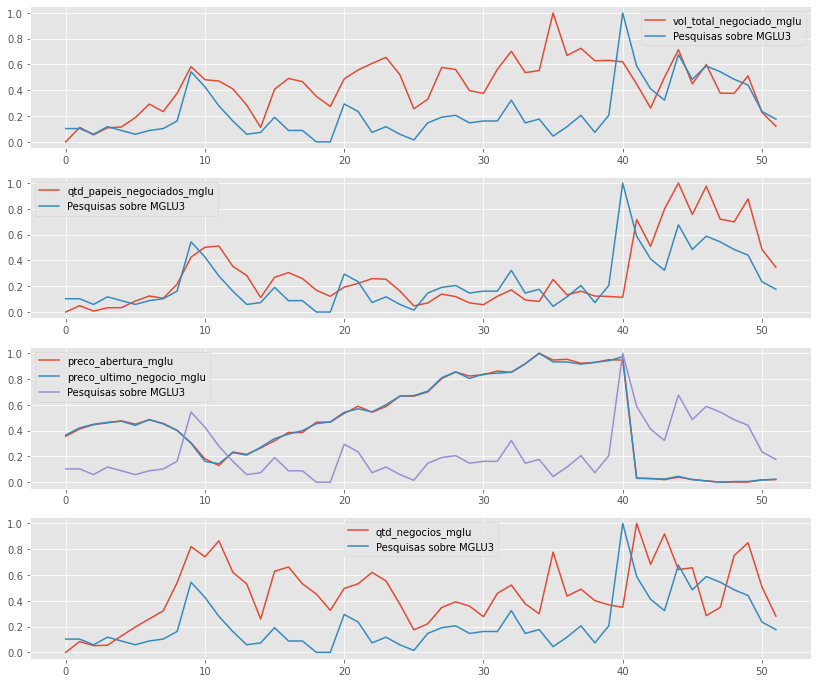

In [31]:
# MGLU3
fig, axes = plt.subplots(nrows = 4, ncols = 1)

# volume financeiro
trend_b3_scaled_vista[['vol_total_negociado_mglu', 'Pesquisas sobre MGLU3']].plot(ax=axes[0], figsize=(14, 12))
# quantidade de papéis negociados (uma operação pode negociar vários papéis)
trend_b3_scaled_vista[['qtd_papeis_negociados_mglu', 'Pesquisas sobre MGLU3']].plot(ax=axes[1], figsize=(14, 12))
# preços
trend_b3_scaled_vista[['preco_abertura_mglu', 'preco_ultimo_negocio_mglu', 'Pesquisas sobre MGLU3']].plot(ax=axes[2], figsize=(14, 12))
# quantidade de negócios (quantidade de operações)
trend_b3_scaled_vista[['qtd_negocios_mglu', 'Pesquisas sobre MGLU3']].plot(ax=axes[3], figsize=(14, 12))

<AxesSubplot:>

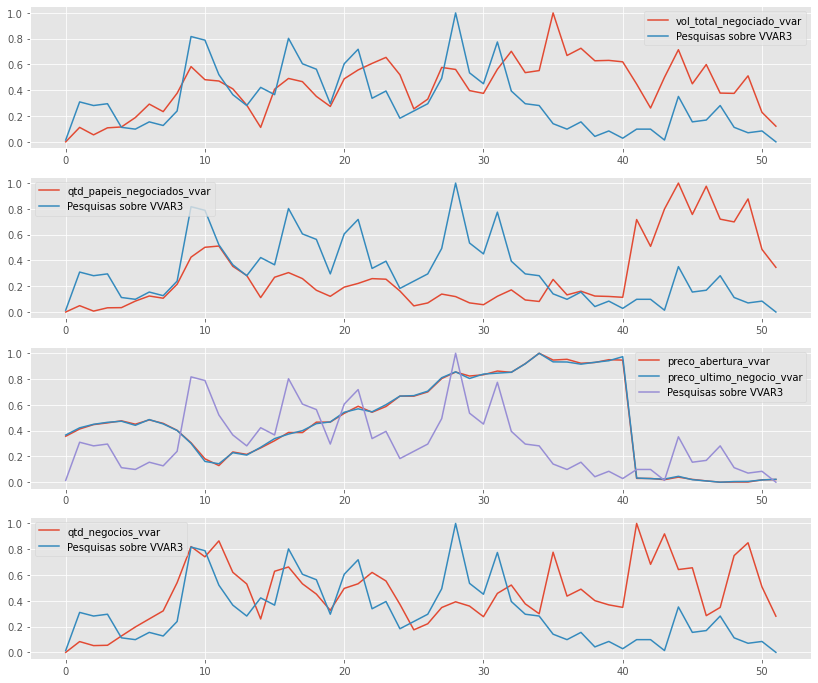

In [33]:
#VVAR3
fig, axes = plt.subplots(nrows = 4, ncols = 1)

trend_b3_scaled_vista[['vol_total_negociado_vvar', 'Pesquisas sobre VVAR3']].plot(ax=axes[0], figsize=(14, 12))
trend_b3_scaled_vista[['qtd_papeis_negociados_vvar', 'Pesquisas sobre VVAR3']].plot(ax=axes[1], figsize=(14, 12))
trend_b3_scaled_vista[['preco_abertura_vvar', 'preco_ultimo_negocio_vvar', 'Pesquisas sobre VVAR3']].plot(ax=axes[2], figsize=(14, 12))
trend_b3_scaled_vista[['qtd_negocios_vvar', 'Pesquisas sobre VVAR3']].plot(ax=axes[3], figsize=(14, 12))

para a Magazine Luiza, parece que tanto no fracionário quanto no a vista a quantidade de papéis negociados acompanhou a quantidade de pesquisas no Google, mas pra Via Varejo só no fracionário